# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.   

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

In [5]:
labels = pd.read_csv('labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42)

Found 7591 validated image filenames.


In [6]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Размер выборки составляет 7591 фото, что является достаточным работы с датасетом, однако выборку можно увеличить с помощью аугментаций для получения лучшего результата.

In [7]:
features, target = next(gen_flow)

In [8]:
features.shape

(32, 224, 224, 3)

In [9]:
target.shape

(32,)

Выведем несколько фото из датасета:

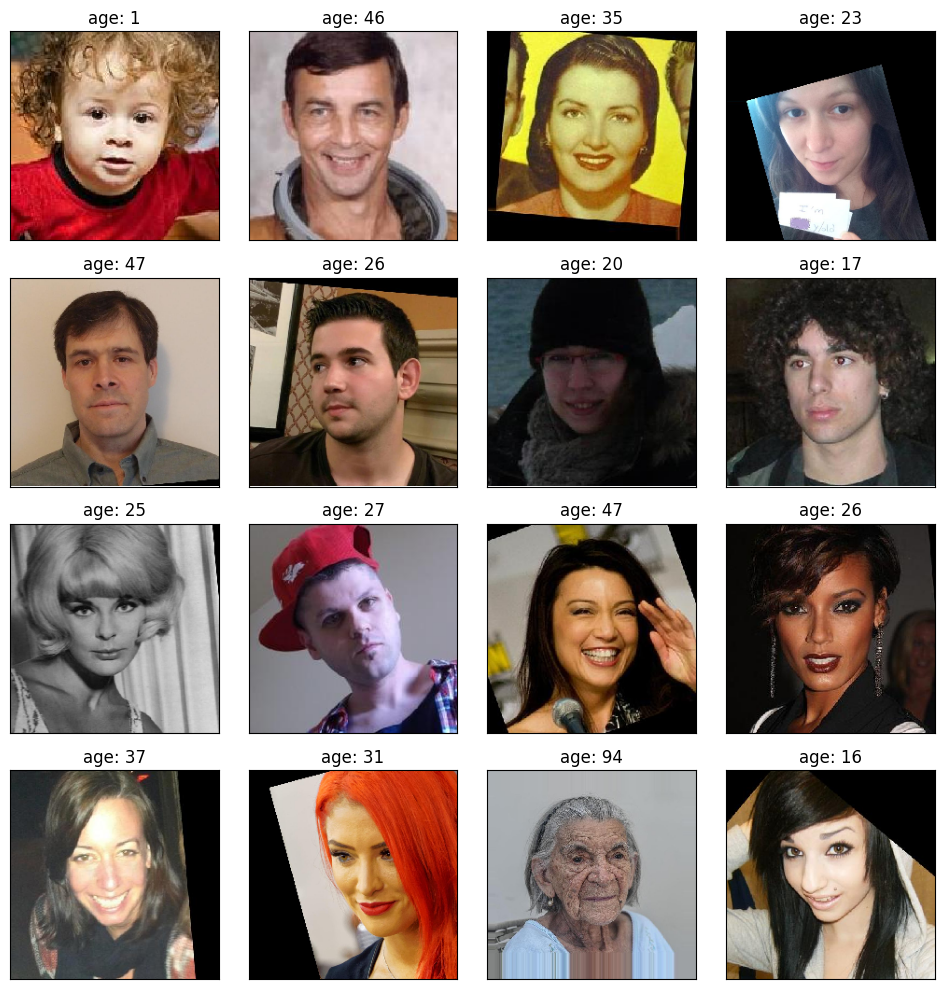

In [10]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'age: {target[i]}')    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете можно увидеть фото, уже прошедшие обработку - присутствуют повернутые, со случайным кропом, черно-белые.

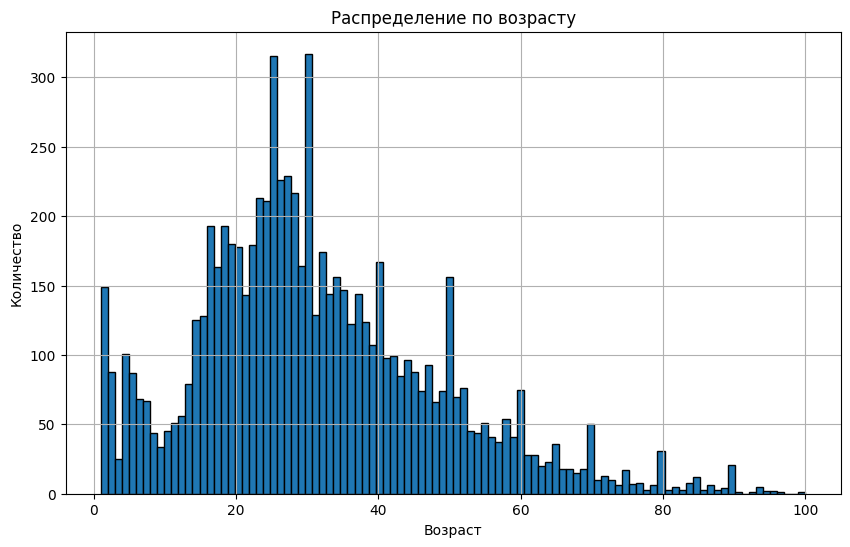

In [11]:
plt.figure(figsize=(10,6))
plt.hist(labels['real_age'], bins=100, edgecolor='black')
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True);

Сильных выбросов и некорректных значений нет.

По итогам анализа можно сделать следующие выводы:

* Размер выборки составляет 7591 фото, что является достаточным работы с датасетом;
* Возраст людей на фото составляет от года до 100 лет, наибольшее число с возрастом от 18 до 40 лет. Также можно увидеть пики на значениях, кратных 10 - 30, 40 , 50 и тд., можно предположить, что на таких фото возраст определялся примерно и округлялся.
* К изображениям уже применены аугментации - определенены лица и вырезаны из фото, фото повернуты так, чтобы лицо располагалось вертикально.
* Из аугментаций к датасету можно применить также horizontal_flip - это позволит увеличить выборку, при этом не силь искажая изображения.

## Обучение модели

In [12]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20, horizontal_flip=True)

train_datagen_flow = train_datagen.flow_from_dataframe(dataframe = labels, 
                                                       directory = ('final_files/'), 
                                                       x_col='file_name',
                                                       y_col='real_age',     
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       shuffle=True,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=42)

Found 6073 validated image filenames.


In [14]:
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)

val_datagen_flow = val_datagen.flow_from_dataframe(dataframe = labels, 
                                                     directory = ('final_files/'),
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     shuffle=False,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=42)

Found 1518 validated image filenames.


In [15]:
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights='imagenet')

In [16]:
backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu')) 

optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

In [117]:
history = model.fit(train_datagen_flow,
          validation_data=val_datagen_flow,
          batch_size=32, epochs=30,
          steps_per_epoch=6073 // 32,
          validation_steps=1518 // 32,
          verbose=2)

Epoch 1/15
189/189 - 1948s - loss: 218.2819 - mae: 11.4037 - val_loss: 432.1129 - val_mae: 17.7626 - 1948s/epoch - 10s/step
Epoch 2/15
189/189 - 1880s - loss: 154.5292 - mae: 9.4568 - val_loss: 359.0083 - val_mae: 14.1125 - 1880s/epoch - 10s/step
Epoch 3/15
189/189 - 1872s - loss: 128.2562 - mae: 8.5633 - val_loss: 298.3213 - val_mae: 12.9326 - 1872s/epoch - 10s/step
Epoch 4/15
189/189 - 1873s - loss: 112.9534 - mae: 8.1133 - val_loss: 276.5818 - val_mae: 12.3524 - 1873s/epoch - 10s/step
Epoch 5/15
189/189 - 1872s - loss: 105.4631 - mae: 7.8181 - val_loss: 158.1495 - val_mae: 9.4086 - 1872s/epoch - 10s/step
Epoch 6/15
189/189 - 1875s - loss: 91.3632 - mae: 7.3252 - val_loss: 120.7119 - val_mae: 8.4422 - 1875s/epoch - 10s/step
Epoch 7/15
189/189 - 1870s - loss: 82.8173 - mae: 6.8870 - val_loss: 252.3512 - val_mae: 11.9208 - 1870s/epoch - 10s/step
Epoch 8/15
189/189 - 1869s - loss: 78.9005 - mae: 6.8305 - val_loss: 174.1312 - val_mae: 9.6838 - 1869s/epoch - 10s/step
Epoch 9/15
189/189 - 

In [26]:
model.save("model.h5")
loaded_model = tf.keras.saving.load_model("model.h5")

In [19]:
from sklearn.metrics import mean_absolute_error

# Получение фактических меток из объекта DataFrameIterator
actual_labels = val_datagen_flow.labels

# Предсказания модели
predictions = loaded_model.predict(val_datagen_flow)

# Вычисление среднего MAE
mae_score = mean_absolute_error(actual_labels, predictions)
print('Average MAE:', mae_score)

48/48 [==============================] - 100s 2s/step
Average MAE: 28.737026968001533


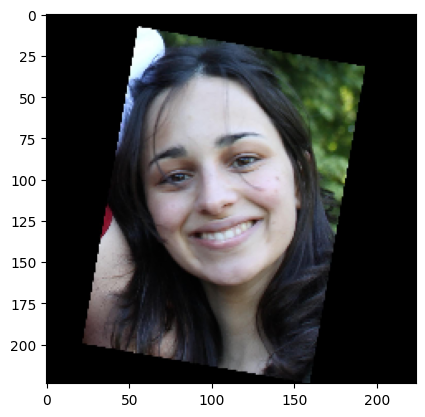

1/1 [==============================] - 0s 159ms/step
Predicted Age: 35.43 years


In [74]:
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input

# Путь к папке с тестовыми изображениями
test_folder = 'final_files/'

# Получение списка файлов в папке "test"
test_images = os.listdir(test_folder)

# Выбор случайной картинки из папки "test"
random_image_filename = random.choice(test_images)
random_image_path = os.path.join(test_folder, random_image_filename)

# # Загрузка и предобработка изображения
img = image.load_img(random_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0
# img_array = preprocess_input(img_array.reshape(1, 224, 224, 3))

# # Вывод изображения
plt.imshow(img)
plt.show()

# # Предсказание с использованием модели
prediction = loaded_model.predict(img_array)
predicted_age = prediction[0][0]

print(f'Predicted Age: {predicted_age:.2f} years')

## Анализ обученной модели

С помощью сети ResNet50, предобученной на датасете ImageNet, было получено значение МАЕ 5.7, что входит в заданное значение до 8, то есть при определении возраста модель ошибается в среднем на 5.7 лет.

Это делает модель непригодной для анализа возраста при продаже алкоголя, однако может быть полезной для того, чтобы предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы - здесь такая погрешность допустима.